## Implement the K mixtures of Gaussian Using Wassrstein Loss Function

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from scipy.sparse import spdiags
from scipy.sparse import kron
from mpl_toolkits.mplot3d import Axes3D
import time
import random
from sklearn.decomposition import PCA, NMF
import scipy.sparse as sp
import scipy.linalg as linalg
from numpy.random import default_rng
import ot
from matplotlib.ticker import LinearLocator

In [3]:
b = .025;

def model(x, k, mu, w):
    result = 0;
    for i in range(k-1):
        result = result + w[i]*multivariate_normal.pdf(x, mean=mu[i], cov=[[.5, 0], [0, .5]]);
    w_last = 1 - np.sum(w);
    result = result + w_last*multivariate_normal.pdf(x, mean=mu[k-1], cov=[[.5, 0], [0, .5]]);
    return result+b;

#it generates and returns random parameters:
#[k-1 weight paras, k means]
def generate_random_para(k):
    mu_x = 0; mu_y = 0;
    if (k<=90):
        mu_x = np.array(random.sample(range(5, 95), k))/10;
        mu_y = np.array(random.sample(range(5, 95), k))/10;
    else:
        mu_x = np.array(random.sample(range(50, 950), k))/100;
        mu_y = np.array(random.sample(range(50, 950), k))/100;
    means = [];
    for i in range(k):
        means.append(np.array([mu_x[i], mu_y[i]]));
    means = np.array(means);
    weights = [random.randrange(40, 60) for i in range(k)];
    weights = np.array(weights);
    weights = weights/np.sum(weights);
    weights = weights[0:k-1];
    return [means, weights]; 

N = 51;
dx = 26/N; dy = 26/N;
bounds = [[-11, 15], [-15.5, 10.5]];
Xi = [i for i in np.arange(bounds[0][0]+dx, bounds[0][1]-0.01, dx)];
Yi = [i for i in np.arange(bounds[1][0]+dx, bounds[1][1]-0.01, dy)];
Xi = np.array(Xi); Yi = np.array(Yi);
xv, yv = np.meshgrid(Xi, Yi, sparse=False, indexing ='ij');
X = np.zeros((len(Xi)*len(Yi), 2));
X[:,0] = xv.reshape(len(Xi)*len(Yi), order='F');
X[:,1] = yv.reshape(len(Xi)*len(Yi), order='F');
costM = ot.dist(X, X);

## Plot the Data

In [4]:
def plot_data(mu, w, xrange, yrange, grid, ang1, ang2, savepath = -1):
    fig, ax = plt.subplots(subplot_kw={"projection":"3d"});
    fig.set_figheight(10)
    fig.set_figwidth(15)
    X = np.arange(xrange[0], xrange[1], grid);
    Y = np.arange(yrange[0], yrange[1], grid);
    X, Y = np.meshgrid(X, Y);
    Z = np.zeros(X.shape)
    for i in range(Y.shape[0]):
        for j in range(X.shape[0]):
            x = X[j][j]; y = Y[i][i];
            Z[i, j] = model(np.array([x, y]), 2, mu, w);    
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(ang1, ang2)
    ax.set_xlabel("x direction");
    ax.set_ylabel("y direction");
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title("2 Mix of Guass: w: {} means: {}".format(w[0], mu));
    if (savepath!=-1):
        plt.savefig(savepath, dpi=300);
        

In [5]:
#X is the mesh grid points we want to evaluate at
#mu, w is the current parameters
#ytruth is the truth values
#normalized the ymodel before computing the distance
def W2loss_dudro(X, k, mu, w, ytruth, costM):
    ymodel = model(X, k, mu, w);
    ymodel /= ymodel.sum();
    _, log = ot.lp.emd(ymodel, ytruth, costM, log = True);
    return [log['cost'], log['u']];

#wrapper function that computes the objective function
#para is the value of mu1 (1d array)
#fix_mu2 is the fixed value of mu2 (1d array)
#fix_w is the fixed value of w (1d array)
def Costobj_mu1(para, fix_mu2, fix_w):
    mu = np.array([para, fix_mu2]);
    return W2loss_dudro(X, 2, mu, fix_w, ytruth, costM)[0];

def Costobj_mu2(para, fix_mu1, fix_w):
    mu = np.array([fix_mu1, para]);
    return W2loss_dudro(X, w, mu, fix_w, ytruth, costM)[0];

#this function updates the parameter mu1
#it returns [new para, new learning rate]
def update_mu1(costobj, para, obj, g, d, lr0, fix_mu2, fix_w):
    # costobj: the function handle that takes x and output the objective function
    # para: the current parameter
    # obj: the latest objective function
    # g: the latest gradient
    # d: descent direction
    # lr0: the initial learning rate
    beta = 0.5; alpha = 1e-4;
    lr = lr0;
    f_new = costobj(para+lr*d, fix_mu2, fix_w); 
    counter = 1;
    while (f_new > obj + alpha*lr*g.dot(d)):
        lr = beta*lr;
        f_new = costobj(para+lr*d, fix_mu2, fix_w);
        counter += 1;
        if (counter > 8):
            print("no descent direction available");
            break;
    return [para + lr*d, lr];

#this function updates the parameter mu2
#it returns [new para, new learning rate]
def update_mu2(costobj, para, obj, g, d, lr0, fix_mu1, fix_w):
    # costobj: the function handle that takes x and output the objective function
    # para: the current parameter
    # obj: the latest objective function
    # g: the latest gradient
    # d: descent direction
    # lr0: the initial learning rate
    beta = 0.5; alpha = 1e-4;
    lr = lr0;
    f_new = costobj(para+lr*d, fix_mu1, fix_w); 
    counter = 1;
    while (f_new > obj + alpha*lr*g.dot(d)):
        lr = beta*lr;
        f_new = costobj(para+lr*d, fix_mu1, fix_w);
        counter += 1;
        if (counter > 8):
            print("no descent direction available");
            break;
    return [para + lr*d, lr];

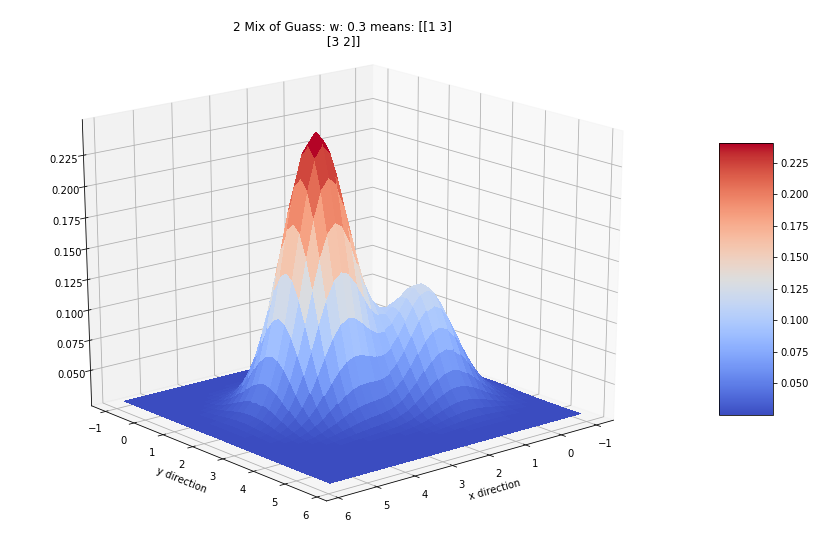

In [6]:
ang1 = 20; ang2 = 50;
plot_data(np.array([[1, 3], [3, 2]]), np.array([.3]), np.array([-1, 6]), 
          np.array([-1, 6]), .2, ang1, ang2, savepath='/Users/leiwanzhou/Desktop/referencemodel.png')

In [7]:
import matplotlib
matplotlib.__version__

'3.1.1'

In [5]:
def expinner(x, mu):
    inner = -0.5*np.einsum("ij, ij->i", x-mu, x-mu);
    return np.exp(inner);  

##it returns the gradient of p w.r.t all the w_i
##returns a matrix of size (N-1)^2*(k-1)
def dpdw(x, mu, w, k):
    result = [];
    for i in range(k-1):
        result.append(multivariate_normal.pdf(x, mean=mu[i], cov=[[.5, 0], [0, .5]]));
    result = result - multivariate_normal.pdf(x, mean=mu[k-1], cov=[[.5, 0], [0, .5]]);
    result = np.array(result);
    result = np.transpose(result);
    return result;

#the derivative dp/dmu1:
def dpdmu(w, x, mu):
    t1 = expinner(x, mu); t2 = (mu-x);
    return -w*(1/(2*np.pi))*np.multiply(t2, t1[:, np.newaxis]);

#it returns a (N-1)^2 by 3k-1 matrix
def p_grad(X, mu, w, k, N):
    result = np.zeros(((N-1)**2, 3*k-1));
    result[:, 0:k-1] = dpdw(X, mu, w, k);
    for i in range(k-1):
        result[:, 2*i+k-1:2*i+k+1] = dpdmu(w[i], X, mu[i]);
    w_last = 1- np.sum(w);
    result[:, 3*k-3:3*k-1] = dpdmu(w_last, X, mu[k-1]);
    return result;

#it returns a (N-1)^2 by 2k matrix
#which is the gradient w.r.t mus only
def p_grad_mu(X, mu, w, k, N):
    result = np.zeros(((N-1)**2, 2*k));
    for i in range(k-1):
        result[:, 2*i:2*i+2] = dpdmu(w[i], X, mu[i]);
    w_last = 1- np.sum(w);
    result[:, 2*k-2:2*k] = dpdmu(w_last, X, mu[k-1]);
    return result;

#it returns the gradient of p together with the gradient of U
#returns [p_grad, u_grad]
def U_grad(X, mu, w, k, N, ytruth, drodu):
    P = p_grad(X, mu, w, k, N);
    Q = drodu.T @ P;
    return [P, Q];

In [6]:
#discretization

#compute the matrix A that represents the process of taking divergence
#returns a 2*(N-1)**2 by (N-1)**2 matrix
def discretize(N, dx, dy):
    ones = np.ones(N-1);
    diags = np.array([-1, 1]);
    data = [-ones, ones];
    B = spdiags(data, diags, N-1, N-1).toarray();
    I = np.identity(N-1);
    A1 = kron(I, B).toarray()/(2*dx);
    A2 = kron(B, I).toarray()/(2*dy);
    return np.concatenate((A1, A2), axis=0);

##compute the matrix sigma
def sigma(X, N, w, mu, k):
    diagonal = 1/model(X, k, mu, w);
    data = np.array([diagonal]);
    diags = np.array([0]);
    sig = spdiags(data, diags, (N-1)**2, (N-1)**2).toarray();
    return sig;

##compute the matrix big sigma
##that is a concatenation of sigma
def Sigma(X, N, w, mu, k):
    sig = sigma(X, N, w, mu, k);
    I = np.identity(2);
    Sig = kron(I, sig).toarray();
    return Sig;

##compute the matrix C
def Cmatrix(X, N, w, mu, k):
    C = Sigma(X, N, w, mu, k);
    C = 2*C;
    C = np.linalg.inv(C);
    return C;

#it returns a bsr_matrix
def Bmatrix(X, N, w, mu, k, A):
    A = sp.bsr_matrix(A.T);
    diagonal = model(X, k, mu, w)**0.5;
    data = np.array([diagonal]);
    diags = np.array([0]);
    sig = spdiags(data, diags, (N-1)**2, (N-1)**2);
    I = sp.identity(2);
    Pinv = kron(I, sig);
    B = A@Pinv; C = Pinv@A.T;
    return [B, C];

## GD on 2 Mixtures of 5 parameters

In [7]:
def quick_sort(numseq, indexseq):
    size = len(numseq);
    if (size<=1):
        return [numseq, indexseq];
    pivot = size//2;
    pivotvalue = numseq.pop(pivot);
    midnum = [pivotvalue];
    midindex = [indexseq.pop(pivot)];
    leftnum = []; rightnum = [];
    leftindex = []; rightindex = [];
    for i in range(size-1):
        if (numseq[i] > pivotvalue):
            leftnum.append(numseq[i]);
            leftindex.append(indexseq[i]);
        else:
            rightnum.append(numseq[i]);
            rightindex.append(indexseq[i]);
    sortednuml, sortedindexl = quick_sort(leftnum, leftindex);
    sortednumr, sortedindexr = quick_sort(rightnum, rightindex);
    return [sortednuml+midnum+sortednumr, sortedindexl+midindex+sortedindexr];

#m is the order of apprximation, the less m is, the quicker the algo 
#but less accurate the return value is
#m must be <= 3k-1
def Natural_dir2(X, N, k, w, mu, ytruth, A, m, drodu):
    B = Bmatrix(X, N, w, mu, k, A);
    B = B.toarray();
    q, r= linalg.qr(B.T, mode = 'economic');
    gradp, gradu = U_grad(X, mu, w, k, N, ytruth, drodu);
    Z = np.linalg.solve(r.T, -gradp);
    Y = np.matmul(q, Z);
    Q, R = linalg.qr(Y, mode = 'economic')
    diag = abs(np.diagonal(R))
    numseq, indexseq = quick_sort(list(diag), list(range(len(diag))))
    Rtil = R[indexseq[0:m], :]
    Q1, R1 = linalg.qr(Rtil.T, mode = 'economic');
    z = np.linalg.solve(R1, Q1.T @ gradu);
    y = np.linalg.solve(R1.T, z);
    x = Q1 @ y;
    return x;

##define 2 functions that transfer parameters from 2 vectors to 1 single vector
def to1(mu, w):
    return np.concatenate((w, mu.flatten()))

def to2(para, k):
    w = para[0:k-1];
    mu = para[k-1:3*k-1];
    return [w, np.reshape(mu, (-1, 2))];

In [8]:
##Wasserstein Natural GD
def Natural_GD_test(lr, initial, iteration, k, N, A, ytruth, costM, savepath):
    para = initial;
    w_initial, mu_initial = to2(initial, k);
    trace = [para]; 
    tracevalue = [];
    start = time.time();
    for i in range(iteration):
        print(i);
        w, mu = to2(para, k);
        Loss, drodu = W2loss_dudro(X, k, mu, w, ytruth, costM);
        direct = Natural_dir2(X, N, k, w, mu, ytruth, A, 5, drodu)
        para = para - lr*direct;
        tracevalue.append(Loss);
        trace.append(para);
    end = time.time();
    trace = np.array(trace);
    tracevalue.append(W2loss_dudro(X, k, mu, w, ytruth, costM)[0])
    weight_trace = trace[:, 0];
    mu1_trace = trace[:, 1:3];
    mu2_trace = trace[:, 3:5];
    #plot the trace of parameters
    fig, ax = plt.subplots(2, 2, figsize=(7, 7));
    ax[0][0].plot(weight_trace);
    ax[0][1].plot(mu1_trace[:, 0], mu1_trace[:, 1], label='mu1 trace');
    ax[0][1].plot(mu2_trace[:, 0], mu2_trace[:, 1], label = 'mu2 trace');
    ax[0][1].plot(1, 3, 'ro', label = 'mu1 truth', c = 'blue');
    ax[0][1].plot(3, 2, 'ro', label = 'mu2 truth', c = 'orange');
    ax[0][1].legend();
    ax[1][0].plot(tracevalue);
    ax[1][1].semilogy(tracevalue);
    ax[0][0].set_title("Trace of Weight");
    ax[0][1].set_title("Trace of mu1 and mu2 in 2d");
    ax[1][0].set_title("Loss value");
    ax[1][1].set_title("Semilogy of Loss value");
    ax[0][0].set_xlabel("Iteration");
    ax[0][0].set_ylabel("Weight Value");
    ax[0][1].set_xlabel("x direction");
    ax[0][1].set_ylabel("y direction");
    ax[1][0].set_xlabel("Iteration");
    ax[1][0].set_ylabel("Loss");
    ax[1][1].set_xlabel("Iteration");
    ax[1][1].set_ylabel("Loss");
    fig.tight_layout();
    print("Initial parameter values:");
    print("Weight: {}  mu1:[{}, {}]  mu2:[{}, {}]".format(initial[0], initial[1], initial[2], 
                                                     initial[3], initial[4]))
    print("Optimized parameter values:");
    print("Weight: {}  mu1:[{}, {}]  mu2:[{}, {}]".format(round(para[0], 2), round(para[1], 2), round(para[2], 2), 
                                                     round(para[3], 2), round(para[4], 2)));
    print("Time for {} steps is {} seconds".format(iteration, end-start));
    print("Average time for each step is {} seconds".format((end-start)/iteration));
    lo = tracevalue[-1];
    print("The loss is {}.".format(lo));
    plt.savefig(savepath, dpi=300);
    

##std GD
def std_GD_test(lr, initial, iteration, k, N, A, ytruth, costM, savepath):
    para = initial;
    w_initial, mu_initial = to2(initial, k);
    trace = [para];
    tracevalue = [];
    start = time.time();
    for i in range(iteration):
        print('std GD in iteration {}'.format(i));
        w, mu = to2(para, k);
        Loss, drodu =  W2loss_dudro(X, k, mu, w, ytruth, costM);
        P = p_grad(X, mu, w, k, N);
        direct = drodu.T @ P;
        para = para + lr*direct;
        tracevalue.append(Loss);
        trace.append(para);
    end = time.time();
    tracevalue.append(W2loss_dudro(X, k, mu, w, ytruth, costM)[0]);
    trace = np.array(trace);
    weight_trace = trace[:, 0];
    mu1_trace = trace[:, 1:3];
    mu2_trace = trace[:, 3:5];
    #plot the trace of parameters
    fig, ax = plt.subplots(2, 2, figsize=(7, 7));
    ax[0][0].plot(weight_trace);
    ax[0][1].plot(mu1_trace[:, 0], mu1_trace[:, 1], label='mu1 trace');
    ax[0][1].plot(mu2_trace[:, 0], mu2_trace[:, 1], label = 'mu2 trace');
    ax[0][1].plot(1, 3, 'ro', label = 'mu1 truth', c = 'blue');
    ax[0][1].plot(3, 2, 'ro', label = 'mu2 truth', c = 'orange');
    ax[0][1].legend();
    ax[1][0].plot(tracevalue);
    ax[1][1].semilogy(tracevalue);
    ax[0][0].set_title("Trace of Weight");
    ax[0][1].set_title("Trace of mu1 and mu2 in 2d");
    ax[1][0].set_title("Loss value");
    ax[1][1].set_title("Semilogy of Loss value");
    ax[0][0].set_xlabel("Iteration");
    ax[0][0].set_ylabel("Weight Value");
    ax[0][1].set_xlabel("x direction");
    ax[0][1].set_ylabel("y direction");
    ax[1][0].set_xlabel("Iteration");
    ax[1][0].set_ylabel("Loss");
    ax[1][1].set_xlabel("Iteration");
    ax[1][1].set_ylabel("Loss");
    fig.tight_layout();
    print("Initial parameter values:");
    print("Weight: {}  mu1:[{}, {}]  mu2:[{}, {}]".format(initial[0], initial[1], initial[2], 
                                                     initial[3], initial[4]))
    print("Optimized parameter values:");
    print("Weight: {}  mu1:[{}, {}]  mu2:[{}, {}]".format(round(para[0], 2), round(para[1], 2), round(para[2], 2), 
                                                     round(para[3], 2), round(para[4], 2)));
    print("Time for {} steps is {} seconds".format(iteration, end-start));
    print("Average time for each step is {} seconds".format((end-start)/iteration));
    lo = tracevalue[-1];
    print("The loss is {}.".format(lo));
    plt.savefig(savepath, dpi=300)
    
##calculate the l2 natural gd direction without any reduction
def l2_Natural_dirFull(X, mu, w, k, N, ytruth, drhoU):
    J= p_grad(X, mu, w, k, N)
    q, r= linalg.qr(J, mode = 'economic');
    return np.linalg.solve(r, -q.T @ drhoU);

def l2_Natural_GD_test(lr, initial, iteration, k, N, A, ytruth, costM, savepath):
    para = initial;
    w_initial, mu_initial = to2(initial, k);
    trace = [para]; 
    tracevalue = [];
    start = time.time();
    for i in range(iteration):
        print(i);
        print(para);
        w, mu = to2(para, k);
        Loss, drodu = W2loss_dudro(X, k, mu, w, ytruth, costM);
        direct = l2_Natural_dirFull(X, mu, w, k, N, ytruth, drodu);
        para = para - lr*direct;
        tracevalue.append(Loss);
        trace.append(para);
    end = time.time();
    tracevalue.append(W2loss_dudro(X, k, mu, w, ytruth, costM)[0]);
    trace = np.array(trace);
    weight_trace = trace[:, 0];
    mu1_trace = trace[:, 1:3];
    mu2_trace = trace[:, 3:5];
    #plot the trace of parameters
    fig, ax = plt.subplots(2, 2, figsize=(7, 7));
    ax[0][0].plot(weight_trace);
    ax[0][1].plot(mu1_trace[:, 0], mu1_trace[:, 1], label='mu1 trace');
    ax[0][1].plot(mu2_trace[:, 0], mu2_trace[:, 1], label = 'mu2 trace');
    ax[0][1].plot(1, 3, 'ro', label = 'mu1 truth', c = 'blue');
    ax[0][1].plot(3, 2, 'ro', label = 'mu2 truth', c = 'orange');
    ax[0][1].legend();
    ax[1][0].plot(tracevalue);
    ax[1][1].semilogy(tracevalue);
    ax[0][0].set_title("Trace of Weight");
    ax[0][1].set_title("Trace of mu1 and mu2 in 2d");
    ax[1][0].set_title("Loss value");
    ax[1][1].set_title("Semilogy of Loss value");
    ax[0][0].set_xlabel("Iteration");
    ax[0][0].set_ylabel("Weight Value");
    ax[0][1].set_xlabel("x direction");
    ax[0][1].set_ylabel("y direction");
    ax[1][0].set_xlabel("Iteration");
    ax[1][0].set_ylabel("Loss");
    ax[1][1].set_xlabel("Iteration");
    ax[1][1].set_ylabel("Loss");
    fig.tight_layout();
    print("Initial parameter values:");
    print("Weight: {}  mu1:[{}, {}]  mu2:[{}, {}]".format(initial[0], initial[1], initial[2], 
                                                     initial[3], initial[4]))
    print("Optimized parameter values:");
    print("Weight: {}  mu1:[{}, {}]  mu2:[{}, {}]".format(round(para[0], 2), round(para[1], 2), round(para[2], 2), 
                                                     round(para[3], 2), round(para[4], 2)));
    print("Time for {} steps is {} seconds".format(iteration, end-start));
    print("Average time for each step is {} seconds".format((end-start)/iteration));
    lo = tracevalue[-1];
    print("The loss is {}.".format(lo));
    plt.savefig(savepath, dpi=300);

In [9]:
k = 2;
A = discretize(51, dx, dy);
w_true = np.array([0.3]);
mu_true = np.array([[1, 3], [3, 2]]);
ytruth = model(X, k, mu_true, w_true);
#normalized ytruth
ytruth = ytruth/ytruth.sum();
initial = np.array([0.8, 4, 4, 4, 3]);
w_initial, mu_initial = to2(initial, 2);

std GD in iteration 0
std GD in iteration 1
std GD in iteration 2
std GD in iteration 3
std GD in iteration 4
std GD in iteration 5
std GD in iteration 6
std GD in iteration 7
std GD in iteration 8
std GD in iteration 9
std GD in iteration 10
std GD in iteration 11
std GD in iteration 12
std GD in iteration 13
std GD in iteration 14
std GD in iteration 15
std GD in iteration 16
std GD in iteration 17
std GD in iteration 18
std GD in iteration 19
std GD in iteration 20
std GD in iteration 21
std GD in iteration 22
std GD in iteration 23
std GD in iteration 24
std GD in iteration 25
std GD in iteration 26
std GD in iteration 27
std GD in iteration 28
std GD in iteration 29
std GD in iteration 30
std GD in iteration 31
std GD in iteration 32
std GD in iteration 33
std GD in iteration 34
std GD in iteration 35
std GD in iteration 36
std GD in iteration 37
std GD in iteration 38
std GD in iteration 39
std GD in iteration 40
std GD in iteration 41
std GD in iteration 42
std GD in iteration 4

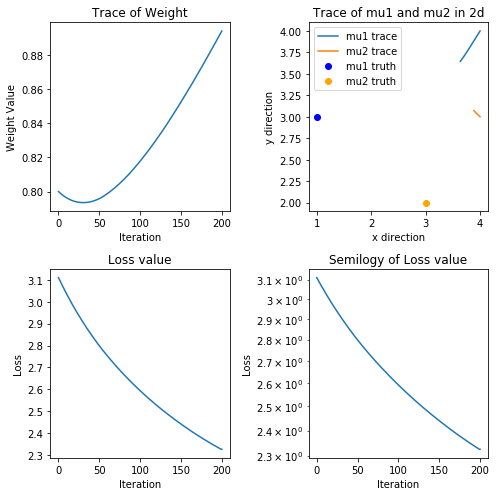

In [26]:
##initial = [0.8, 4, 4, 4, 3]
savepath = "/Users/leiwanzhou/Desktop/Wasserstein-5para/std-d8-4443-d00005"
std_GD_test(0.00005, np.array([0.8, 4, 4, 4, 3]), 200, 2, 31, A, ytruth, costM, savepath);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

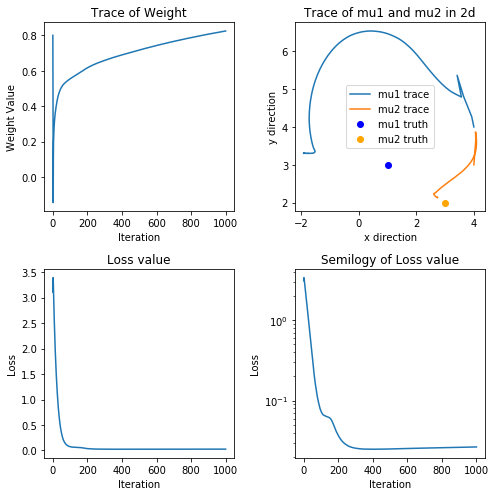

In [25]:
##initial = [0.8, 4, 4, 4, 3]
savepath = "/Users/leiwanzhou/Desktop/Wasserstein-5para/nat-d8-4443-d0125"
Natural_GD_test(0.0125, np.array([0.8, 4, 4, 4, 3]), 1000, 2, 31, A, ytruth, costM, savepath);

0
[0.8 4.  4.  4.  3. ]
1
[0.81373314 3.99948263 3.98826329 3.99910843 2.96508419]
2
[0.82611644 3.99896154 3.97751742 3.99811884 2.93044809]
3
[0.83721612 3.99843958 3.96771154 3.99703108 2.8963829 ]
4
[0.84721343 3.99791318 3.95870308 3.99583381 2.86281155]
5
[0.85624095 3.99738291 3.95039567 3.99451597 2.82972464]
6
[0.86438152 3.99684775 3.94273374 3.99307938 2.79727294]
7
[0.87169691 3.99631046 3.9356849  3.99154072 2.76567793]
8
[0.87831944 3.99576815 3.9291505  3.98988207 2.73479232]
9
[0.88432719 3.99522101 3.92307877 3.98810214 2.70464091]
10
[0.88979178 3.99466923 3.91742174 3.98619922 2.6752249 ]
11
[0.89477273 3.99411272 3.91214007 3.98417628 2.64656384]
12
[0.89932898 3.99355096 3.90719297 3.9820415  2.61861989]
13
[0.90350418 3.99298631 3.90255133 3.97978391 2.59141965]
14
[0.90733918 3.99241719 3.89818799 3.97741397 2.56496322]
15
[0.91087093 3.99184372 3.89407734 3.9749353  2.53923945]
16
[0.91410023 3.99127322 3.89023538 3.97238174 2.51452213]
17
[0.91709258 3.99069885

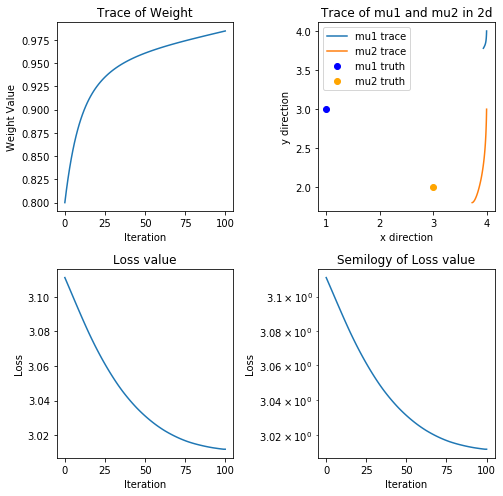

In [41]:
##initial = [0.8, 4, 4, 4, 3]
savepath = "/Users/leiwanzhou/Desktop/Wasserstein-5para/l2-d8-4443-d1"
l2_Natural_GD_test(0.00001, np.array([0.8, 4, 4, 4, 3]), 100, 2, 31, A, ytruth, costM, savepath);

## GD on 2 mixtures of 4 parameters

In [10]:
#the derivative dp/dmu1:
def dpdmu1(w, x, mu1):
    t1 = expinner(x, mu1); t2 = (mu1-x);
    return -w*(1/(2*np.pi))*np.multiply(t2, t1[:, np.newaxis]);
    
#the derivative dp/dmu2:
def dpdmu2(w, x, mu2):
    t1 = expinner(x, mu2); t2 = (mu2-x);
    return (w-1)*(1/(2*np.pi))*np.multiply(t2, t1[:, np.newaxis]);

##this function returns the gradient of p and U w.r.t mu1 only
def gradient_mu1_all(X, w, mu1, mu2, drodu):
    dpmu1 = dpdmu1(w, X, mu1);
    Q = np.sum(np.multiply(dpmu1, drodu[:, np.newaxis]), axis=0);
    return [dpmu1, Q];

##this function returns the gradient of p and U w.r.t mu2 only
def gradient_mu2_all(X, w, mu1, mu2, drodu):
    dpmu2 = dpdmu2(w, X, mu2);
    Q = np.sum(np.multiply(dpmu2, drodu[:, np.newaxis]), axis=0);
    return [dpmu2, Q];

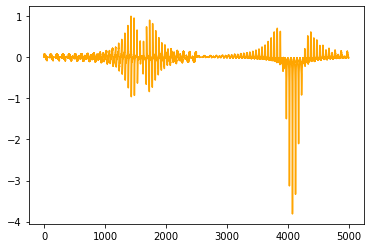

In [165]:
plt.plot(Y[:, 1], c='orange')

In [12]:
mu = np.array([[1, 3], [3, 2]])
N2 = 51;
wide = 18;
dx2 = wide/N2; dy2 = wide/N2;
X2 = [];
for i in range(1, N2):
    for j in range(1, N2):
        X2.append([dx2*i, dy2*j]);
X2= np.array(X2);
X2[:, 0] = X2[:, 0] - wide/2 + 2; 
X2[:, 1] = X2[:, 1] - wide/2 + 2.5;
X2 = np.array(X2);
A2 = discretize(N2, dx2, dy2);
B, C = Bmatrix(X2, N2, w, mu, 2, A2);
B = B.toarray(); C = C.toarray();
q, r= linalg.qr(B.T, mode = 'economic');
gradp = dpdmu1(w[0], X2, mu[0]);
Z = np.linalg.solve(r.T, -gradp);
Y = q@Z;
print("matrix Y:");
print(Y)
print("matrix B:");
print(B);
print("gradp:");
print(gradp);

matrix Y:
[[ 5.98421282e-03  4.29461060e-04]
 [ 4.59075325e-04 -1.81266593e-04]
 [ 6.02409964e-03  3.45925001e-04]
 ...
 [ 2.55295961e-04  4.78960472e-03]
 [ 3.08040785e-04  8.97507468e-05]
 [ 1.81012375e-04  4.82568219e-03]]
matrix B:
[[ 0.         -0.22399467  0.         ...  0.          0.
   0.        ]
 [ 0.22399467  0.         -0.22399467 ...  0.          0.
   0.        ]
 [ 0.          0.22399467  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
gradp:
[[-4.96343145e-32 -5.93702762e-32]
 [-1.17705682e-30 -1.35361535e-30]
 [-2.46441511e-29 -2.72033515e-29]
 ...
 [ 2.69577485e-33  2.07936292e-33]
 [ 1.83251521e-34  1.48053820e-34]
 [ 1.09979716e-35  9.28792110e-36]]


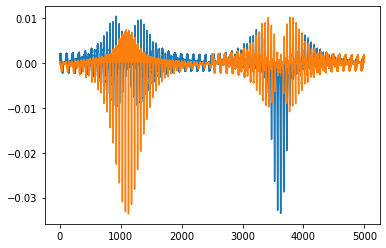

In [125]:
plt.plot(Y[:, 0])
plt.plot(Y[:, 1])

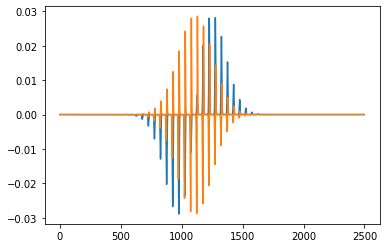

In [124]:
plt.plot(gradp[:, 0])
plt.plot(gradp[:, 1])

In [19]:
def Natural_dir_mu1(X, N, w, mu, drodu, A):
    B,C = Bmatrix(X, N, w, mu, 2, A);
    B = B.toarray(); C = C.toarray();
    q, r= linalg.qr(B.T, mode = 'economic');
    gradp = dpdmu1(w[0], X, mu[0]);
    Z = np.linalg.solve(r.T, -gradp);
    Y = np.matmul(q, Z);
    Q, R = linalg.qr(Y, mode = 'economic');
    RHS = -Q.T@C@drodu;
    x = np.linalg.solve(R, RHS);
    return x;

def Natural_dir_mu2(X, N, w, mu, drodu, A):
    B,C = Bmatrix(X, N, w, mu, 2, A);
    B = B.toarray(); C = C.toarray();
    q, r= linalg.qr(B.T, mode = 'economic');
    gradp = dpdmu2(w[0], X, mu[1]);
    Z = np.linalg.solve(r.T, -gradp);
    Y = np.matmul(q, Z);
    Q, R = linalg.qr(Y, mode = 'economic')
    x = np.linalg.solve(R, -Q.T@C@drodu);
    return x;

def Natural_dir_mu1_test(X, N, w, mu, drodu, A):
    B,C = Bmatrix(X, N, w, mu, 2, A);
    B = B.toarray(); C = C.toarray();
    q, r= linalg.qr(B.T, mode = 'economic');
    gradp = dpdmu1(w[0], X, mu[0]);
    Z = np.linalg.solve(r.T, -gradp);
    Y = np.matmul(q, Z);
    print("norm of Y:");
    norm = np.linalg.norm(Y);
    print(norm);
    Y/= Y.max();
    Q, R = linalg.qr(Y, mode = 'economic');
    print("matrix Y:");
    print(Y);
    print("matrix Q:");
    print(Q);
    print("matrix R");
    print(R);
    print("norm of QR-Y: {}".format(np.linalg.norm(Q@R - Y)));
    RHS = -Q.T@C@drodu;
    x = np.linalg.solve(R, RHS);
    print("RHS: {}".format(RHS));
    print("Direction: {}".format(x));
    return [x, Y];

def Natural_dir_mu2(X, N, w, mu, drodu, A):
    B,C = Bmatrix(X, N, w, mu, 2, A);
    B = B.toarray(); C = C.toarray();
    q, r= linalg.qr(B.T, mode = 'economic');
    gradp = dpdmu2(w[0], X, mu[1]);
    Z = np.linalg.solve(r.T, -gradp);
    Y = np.matmul(q, Z);
    Q, R = linalg.qr(Y, mode = 'economic')
    x = np.linalg.solve(R, -Q.T@C@drodu);
    return x;

##calculate the l2 natural gd direction without any reduction
##w is an array of weights, mu is an array of means
def l2_Natural_dirFull_mu1(X, mu, w, N, drodu):
    J = dpdmu1(w[0], X, mu[0]);
    q, r= linalg.qr(J, mode = 'economic');
    return np.linalg.solve(r, -q.T @ drodu);

##calculate the l2 natural gd direction without any reduction
##w is an array of weights, mu is an array of means
def l2_Natural_dirFull_mu2(X, mu, w, N, drodu):
    J = dpdmu2(w[0], X, mu[1]);
    q, r= linalg.qr(J, mode = 'economic');
    return np.linalg.solve(r, -q.T @ drodu);

In [14]:
##constant grid
##this is the grid that is used to plot the loss function 
grid = 0.4;

def compute_intersection_mu1(X, w, mu2, grid, xrange, yrange, ytruth, costM):
    x = np.arange(xrange[0],xrange[1],grid);
    y = np.arange(yrange[0],yrange[1],grid);
    Z = np.zeros((x.size, y.size));
    for i in range(x.size):
        for j in range(y.size):
            print("{}, {}".format(i, j));
            mu = np.array([np.array([grid*i+xrange[0], grid*j+yrange[0]]), mu2]);
            Z[i, j] = W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM)[0];
    return Z;

def compute_intersection_mu2(X, w, mu1, grid, xrange, yrange, ytruth, costM):
    x = np.arange(xrange[0],xrange[1],grid);
    y = np.arange(yrange[0],yrange[1],grid);
    Z = np.zeros((x.size, y.size));
    for i in range(x.size):
        for j in range(y.size):
            print("{}, {}".format(i, j));
            mu = np.array([mu1, np.array([grid*i+xrange[0], grid*j+yrange[0]])]);
            Z[i, j] = W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM)[0];
    return Z;

##it plots the loss function with fixed w, mu2
##it also plots the convergence history of mu1 given the trace and tracevalue paras
def plot_loss_mu1(Z, grid, xrange, yrange, trace, tracevalue, savepath1, savepath2):
    x = np.arange(xrange[0],xrange[1],grid);
    y = np.arange(yrange[0],yrange[1],grid);
    P,Q = np.meshgrid(x,y)
    fig, ax = plt.subplots(figsize=(7, 7));
    level = np.arange(0, 7, 0.1);
    CS = ax.contour(Q, P, Z,levels = level);
    ax.clabel(CS, inline=True, fontsize=10);
    ax.plot(trace[:, 0], trace[:, 1], "*-", c='red');
    ax.set_title('Wasserstein Loss Function w.r.t mu1')
    plt.savefig(savepath1, dpi=300);
    fig, ax = plt.subplots(1, 2, figsize=(8, 4));
    ax[0].plot(tracevalue, label = 'the loss value');
    ax[1].semilogy(tracevalue, label = 'semilogy loss value')
    ax[0].legend();
    ax[1].legend();
    ax[0].set_xlabel("number of iteration")
    ax[1].set_xlabel("number of iteration")
    ax[0].set_ylabel("Loss value")
    fig.suptitle('Loss along the Trace');
    plt.savefig(savepath2, dpi=300);
    
def plot_loss_mu2(Z, grid, xrange, yrange, trace, tracevalue, savepath1, savepath2):
    x = np.arange(xrange[0],xrange[1],grid);
    y = np.arange(yrange[0],yrange[1],grid);
    P,Q = np.meshgrid(x,y)
    fig, ax = plt.subplots(figsize=(7, 7));
    level = np.arange(0, 16, 0.3);
    CS = ax.contour(Q, P, Z,levels = level);
    ax.clabel(CS, inline=True, fontsize=10);
    ax.plot(trace[:, 0], trace[:, 1], "*-", c='red');
    ax.set_title('Loss Function w.r.t mu2')
    plt.savefig(savepath1, dpi=300);
    fig, ax = plt.subplots(1, 2, figsize=(8, 4));
    ax[0].plot(tracevalue, label = 'the loss value');
    ax[1].semilogy(tracevalue, label = 'semilogy loss value')
    ax[0].legend();
    ax[1].legend();
    ax[0].set_xlabel("number of iteration")
    ax[1].set_xlabel("number of iteration")
    ax[0].set_ylabel("Loss value")
    fig.suptitle('Loss along the Trace');
    plt.savefig(savepath2, dpi=300);

In [21]:
##natural gradient descent on mu1 only with fixed w and mu2
#Z, grid, xrange, yrange, trace, tracevalue, savepath1, savepath2
def Natural_GD_mu1(X, Z, w, mu2, lr, initial, iteration, plotrange, ytruth, costM, savepath1, savepath2):
    para = initial; trace = [para]; tracevalue = [];
    start = time.time();
    for i in range(iteration):
        print(i)
        mu = np.array([para, mu2]);
        Loss, drodu = W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM);
        direct = Natural_dir_mu1(X, N, np.array([w]), mu, drodu, A);
        p, gradU = gradient_mu1_all(X, w, para, mu2, drodu);
        para, lr = update_mu1(Costobj_mu1, para, Loss, gradU, -direct, lr, mu2, w);
        trace.append(para);
        tracevalue.append(Loss);
    end = time.time();
    tracevalue.append(W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM)[0]);
    trace = np.array(trace); tracevalue = np.array(tracevalue);
    plot_loss_mu1(Z, grid, plotrange[0], plotrange[1],trace, tracevalue, savepath1, savepath2);
    print("Initial parameter values:");
    print("mu1:[{},{}] ".format(initial[0], initial[1]))
    print("Optimized parameter values:");
    print("mu1:[{}, {}] ".format(round(para[0], 2), round(para[1], 2)));
    print("Time for {} steps is {} seconds.".format(iteration, end-start));
    print("The average time for each step is {} seconds.".format((end-start)/iteration));
    return [trace, tracevalue];
    
##natural gradient descent on mu2 only with fixed w and mu1
def Natural_GD_mu2(X, Z, w, mu1, lr, initial, iteration, plotrange, ytruth, costM, savepath1, savepath2):
    para = initial; trace = [para]; tracevalue = [];
    start = time.time();
    for i in range(iteration):
        print(i);
        mu = np.array([mu1, para]);
        Loss, drodu = W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM);
        p, gradU = gradient_mu2_all(X, w, mu1, para, drodu);
        direct = Natural_dir_mu2(X, N, np.array([w]), mu, drodu, A);
        para, lr = update_mu2(Costobj_mu2, para, Loss, gradU, -direct, lr, mu1, w);
        trace.append(para);
        tracevalue.append(Loss);
    end = time.time();
    tracevalue.append(W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM)[0]);
    trace = np.array(trace); tracevalue = np.array(tracevalue);
    plot_loss_mu2(Z, grid, plotrange[0], plotrange[1], trace, tracevalue, savepath1, savepath2);
    print("Initial parameter values:");
    print("mu2:[{},{}] ".format(initial[0], initial[1]))
    print("Optimized parameter values:");
    print("mu2:[{}, {}] ".format(round(para[0], 2), round(para[1], 2)));
    print("Time for {} steps is {} seconds.".format(iteration, end-start));
    print("The average time for each step is {} seconds.".format((end-start)/iteration));
    return [trace, tracevalue];
    
##std gradient descent on mu1 only with fixed w and mu2
def std_GD_mu1(X, Z, w, mu2, lr, initial, iteration, plotrange, ytruth, costM, savepath1, savepath2):
    para = initial; trace = [para]; tracevalue = [];
    start = time.time();
    for i in range(iteration):
        print(i);
        mu = np.array([para, mu2]);
        Loss, drodu = W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM);
        p, direct = gradient_mu1_all(X, w, para, mu2, drodu)
        para, lr = update_mu1(Costobj_mu1, para, Loss, direct, -direct, lr, mu2, w);
        trace.append(para);
        tracevalue.append(Loss);
    end = time.time();
    tracevalue.append(W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM)[0]);
    trace = np.array(trace); tracevalue = np.array(tracevalue);
    plot_loss_mu1(Z, grid, plotrange[0], plotrange[1],trace, tracevalue, savepath1, savepath2);
    print("Initial parameter values:");
    print("mu1:[{},{}] ".format(initial[0], initial[1]))
    print("Optimized parameter values:");
    print("mu1:[{}, {}] ".format(round(para[0], 2), round(para[1], 2)));
    print("Time for {} steps is {} seconds.".format(iteration, end-start));
    print("The average time for each step is {} seconds.".format((end-start)/iteration));
    return [trace, tracevalue];
    
##std gradient descent on mu1 only with fixed w and mu2
def std_GD_mu2(X, Z, w, mu1, lr, initial, iteration, plotrange, ytruth, costM, savepath1, savepath2):
    para = initial; trace = [para]; tracevalue = [];
    start = time.time();
    for i in range(iteration):
        print(i);
        mu = np.array([mu1, para]);
        Loss, drodu = W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM);
        p, direct = gradient_mu2_all(X, w, mu1, para, drodu);
        para, lr = update_mu2(Costobj_mu2, para, Loss, direct, -direct, lr, mu1, w);
        trace.append(para);
        tracevalue.append(Loss);
    end = time.time();
    tracevalue.append(W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM)[0]);
    trace = np.array(trace); tracevalue = np.array(tracevalue);
    plot_loss_mu2(Z, grid, plotrange[0], plotrange[1], trace, tracevalue, savepath1, savepath2);
    print("Initial parameter values:");
    print("mu1:[{},{}] ".format(initial[0], initial[1]))
    print("Optimized parameter values:");
    print("mu1:[{}, {}] ".format(round(para[0], 2), round(para[1], 2)));
    print("Time for {} steps is {} seconds.".format(iteration, end-start));
    print("The average time for each step is {} seconds.".format((end-start)/iteration));
    return [trace, tracevalue];
    
##l2 natural gradient descent on mu1 only with fixed w and mu2
def l2_Natural_GD_mu1(X, Z, w, mu2, lr, initial, iteration, plotrange, ytruth, costM, savepath1, savepath2):
    para = initial; trace = [para]; tracevalue = [];
    start = time.time();
    for i in range(iteration):
        print(i);
        mu = np.array([para, mu2]);
        Loss, drodu = W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM);
        direct = l2_Natural_dirFull_mu1(X, mu, np.array([w]), 31, drodu);
        p, gradU = gradient_mu1_all(X, w, para, mu2, drodu)
        para, lr = update_mu1(Costobj_mu1, para, Loss, gradU, direct, lr, mu2, w);
        trace.append(para);
        tracevalue.append(Loss);
    end = time.time();
    tracevalue.append(W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM)[0]);
    trace = np.array(trace); tracevalue = np.array(tracevalue);
    plot_loss_mu1(Z, grid, plotrange[0], plotrange[1],trace, tracevalue, savepath1, savepath2);
    print("Initial parameter values:");
    print("mu1:[{},{}] ".format(initial[0], initial[1]))
    print("Optimized parameter values:");
    print("mu1:[{}, {}] ".format(round(para[0], 2), round(para[1], 2)));
    print("Time for {} steps is {} seconds.".format(iteration, end-start));
    print("The average time for each step is {} seconds.".format((end-start)/iteration));
    return [trace, tracevalue];

##l2 natural gradient descent on mu1 only with fixed w and mu1
def l2_Natural_GD_mu2(X, Z, w, mu1, lr, initial, iteration, plotrange, ytruth, costM, savepath1, savepath2):
    para = initial; trace = [para]; tracevalue = [];
    start = time.time();
    for i in range(iteration):
        print(i);
        mu = np.array([mu1, para]);
        Loss, drodu = W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM);
        direct = l2_Natural_dirFull_mu2(X, mu, np.array([w]), 31, drodu);
        p, gradU = gradient_mu2_all(X, w, para, mu1, drodu);
        para, lr = update_mu2(Costobj_mu2, para, Loss, gradU, direct, lr, mu1, w);
        trace.append(para);
        tracevalue.append(Loss);
    end = time.time();
    tracevalue.append(W2loss_dudro(X, 2, mu, np.array([w]), ytruth, costM)[0]);
    trace = np.array(trace); tracevalue = np.array(tracevalue);
    plot_loss_mu2(Z, grid, plotrange[0], plotrange[1], trace, tracevalue, savepath1, savepath2);
    print("Initial parameter values:");
    print("mu2:[{},{}] ".format(initial[0], initial[1]))
    print("Optimized parameter values:");
    print("mu2:[{}, {}] ".format(round(para[0], 2), round(para[1], 2)));
    print("Time for {} steps is {} seconds.".format(iteration, end-start));
    print("The average time for each step is {} seconds.".format((end-start)/iteration));
    return [trace, tracevalue];

In [ ]:
##define the mu1 intersection 
Z_mu1 = compute_intersection_mu1(X, 0.3, np.array([3, 2]), .4, np.array([-1.5, 5.5]), np.array([-1, 6]), ytruth, costM);

In [ ]:
np.savetxt('/Users/leiwanzhou/Desktop/Wasserstein-4para/data-mu1-itersection-d3-n1d55d532.csv', Z_mu1, fmt='%.18e', delimiter=',');

In [16]:
Z_mu1 = np.genfromtxt('/Users/leiwanzhou/Desktop/Wasserstein-4para/data-mu1-itersection-d3-n1d55d532.csv', delimiter = ',');

In [ ]:
##define the mu2 itersection
Z_mu2 = compute_intersection_mu2(X, 0.3, np.array([1, 3]), .4, np.array([-1, 6]), np.array([-1, 6]), ytruth, costM);

In [ ]:
np.savetxt('/Users/leiwanzhou/Desktop/Wasserstein-4para/data-mu2-itersection-d3-13-grdd4-rangen16n16.csv', Z_mu2, fmt='%.18e', delimiter=',');

In [17]:
Z_mu2 = np.genfromtxt('/Users/leiwanzhou/Desktop/Wasserstein-4para/data-mu2-itersection-d3-13-grdd4-rangen16n16.csv', delimiter = ',');

In [ ]:
# Z_mu2b = compute_intersection_mu1(X, 0.3, np.array([3, 2]), .4, np.array([-1.5, 5.5]), np.array([-1, 6]), ytruth, costM);

## Experiment 1: initial: 0, 6, 3, 2 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
Initial parameter values:
mu1:[0,6] 
Optimized parameter values:
mu1:[1.0, 3.0] 
Time for 80 steps is 160.11625027656555 seconds.
The average time for each step is 2.0014531284570696 seconds.


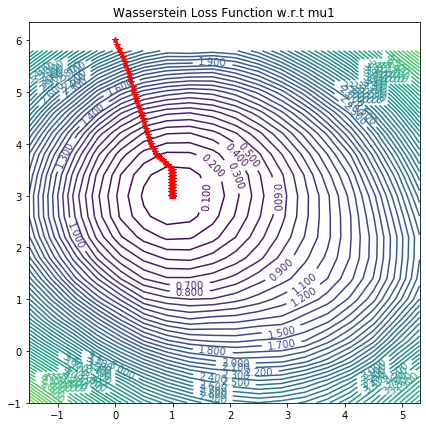

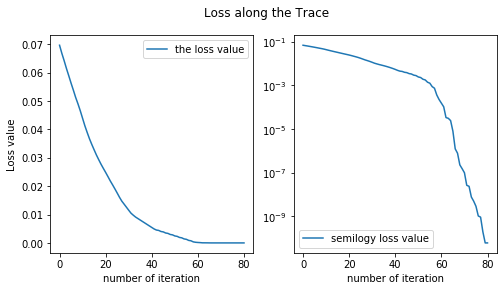

In [27]:
savepath1 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/std-GD-mu1-d3-0632-d05-contour"
savepath2 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/std-GD-mu1-d3-0632-d05-trace"
prange_mu1 = np.array([[-1, 6], [-1.5, 5.5]]);
std_GD_mu1_trace, std_GD_mu1_value = std_GD_mu1(X, Z_mu1, np.array([.3]), np.array([3, 2]), .05, np.array([0, 6]), 80, prange_mu1, ytruth, costM, savepath1, savepath2);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Initial parameter values:
mu1:[0,6] 
Optimized parameter values:
mu1:[1.0, 3.0] 
Time for 100 steps is 383.3644292354584 seconds.
The average time for each step is 3.8336442923545837 seconds.


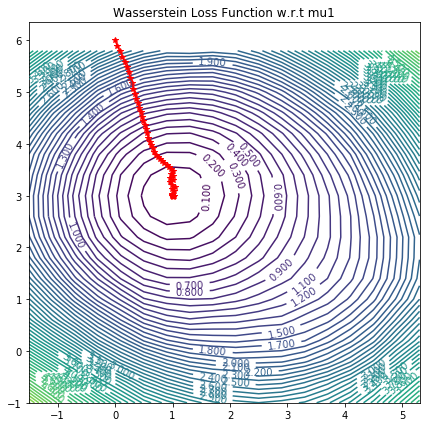

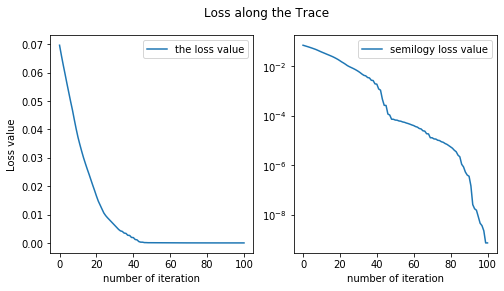

In [35]:
savepath1 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/nat-GD-mu1-d3-0632-d02-bd025-contour"
savepath2 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/nat-GD-mu1-d3-0632-d02-bd025-trace"
prange_mu1 = np.array([[-1, 6], [-1.5, 5.5]]);
nat_GD_mu1_trace, nat_GD_mu1_value = Natural_GD_mu1(X, Z_mu1, np.array([.3]), np.array([3, 2]), .02, 
             np.array([0, 6]), 100, prange_mu1, ytruth, costM, savepath1, savepath2);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Initial parameter values:
mu1:[0,6] 
Optimized parameter values:
mu1:[1.0, 3.0] 
Time for 100 steps is 199.92565035820007 seconds.
The average time for each step is 1.9992565035820007 seconds.


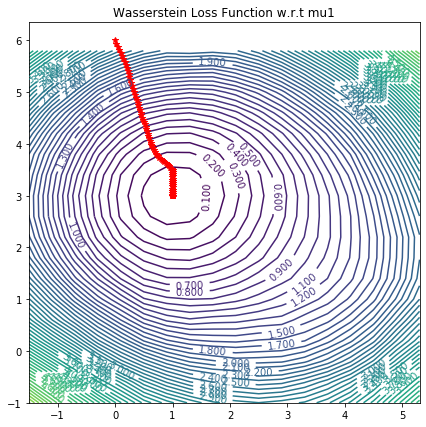

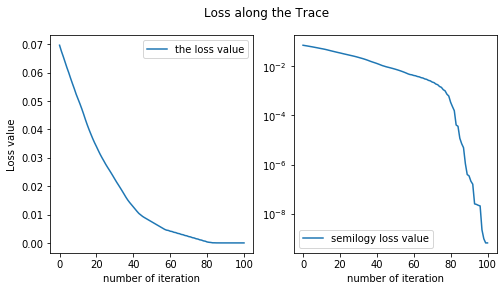

In [37]:
savepath1 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/l2-GD-mu1-d3-0632-d0005-contour"
savepath2 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/l2-GD-mu1-d3-0632-d0005-trace"
prange_mu1 = np.array([[-1, 6], [-1.5, 5.5]]);
l2_GD_mu1_trace, l2_GD_mu1_value = l2_Natural_GD_mu1(X, Z_mu1, np.array([.3]), np.array([3, 2]), .0005, 
             np.array([0, 6]), 100, prange_mu1, ytruth, costM, savepath1, savepath2);

#### Experiment 2: initial: 2, 1, 3, 2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
Initial parameter values:
mu1:[2,1] 
Optimized parameter values:
mu1:[1.0, 3.0] 
Time for 80 steps is 165.34737992286682 seconds.
The average time for each step is 2.0668422490358354 seconds.


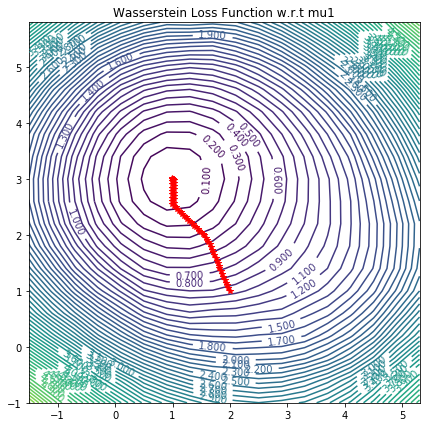

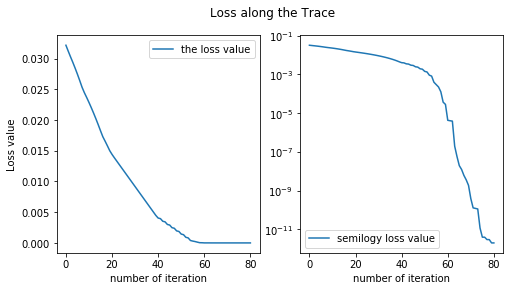

In [39]:
savepath1 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/std-GD-mu1-d3-2132-d05-contour"
savepath2 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/std-GD-mu1-d3-2132-d05-trace"
prange_mu1 = np.array([[-1, 6], [-1.5, 5.5]]);
std_GD_mu1_trace, std_GD_mu1_value = std_GD_mu1(X, Z_mu1, np.array([.3]), np.array([3, 2]), .05, 
             np.array([2, 1]), 80, prange_mu1, ytruth, costM, savepath1, savepath2);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Initial parameter values:
mu1:[2,1] 
Optimized parameter values:
mu1:[1.0, 3.0] 
Time for 100 steps is 298.50696897506714 seconds.
The average time for each step is 2.9850696897506714 seconds.


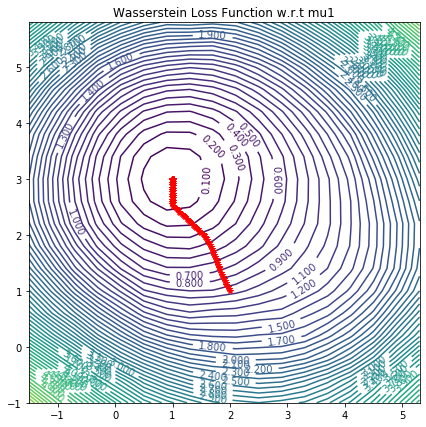

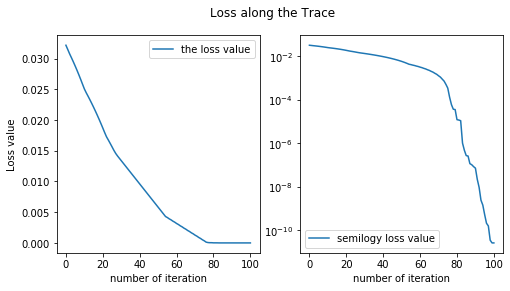

In [42]:
savepath1 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/l2-GD-mu1-d3-2132-d0005-contour"
savepath2 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/l2-GD-mu1-d3-2132-d0005-trace"
prange_mu1 = np.array([[-1, 6], [-1.5, 5.5]]);
l2_GD_mu1_trace, l2_GD_mu1_value = l2_Natural_GD_mu1(X, Z_mu1, np.array([.3]), np.array([3, 2]), .0005, 
             np.array([2, 1]), 100, prange_mu1, ytruth, costM, savepath1, savepath2);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
Initial parameter values:
mu1:[2,1] 
Optimized parameter values:
mu1:[1.0, 3.0] 
Time for 60 steps is 262.22595500946045 seconds.
The average time for each step is 4.370432583491008 seconds.


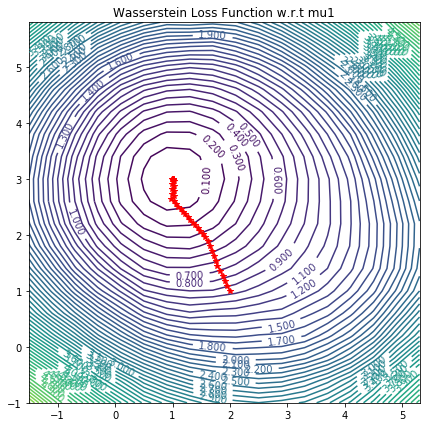

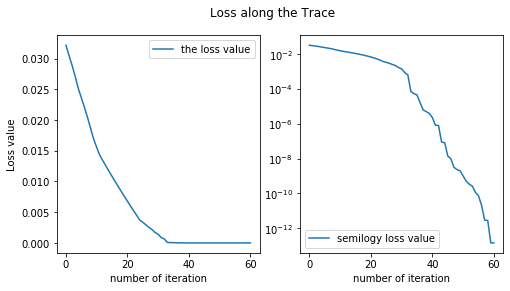

In [44]:
savepath1 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/nat-GD-mu1-d3-2132-d02-bd025-contour"
savepath2 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/nat-GD-mu1-d3-2132-d02-bd025-trace"
prange_mu1 = np.array([[-1, 6], [-1.5, 5.5]]);
nat_GD_mu1_trace, nat_GD_mu1_value = Natural_GD_mu1(X, Z_mu1, np.array([.3]), np.array([3, 2]), .02, 
             np.array([2, 1]), 60, prange_mu1, ytruth, costM, savepath1, savepath2);

## Experiment 3: initial: 4, 4, 3, 2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Initial parameter values:
mu1:[4,4] 
Optimized parameter values:
mu1:[1.0, 3.0] 
Time for 100 steps is 314.533695936203 seconds.
The average time for each step is 3.14533695936203 seconds.


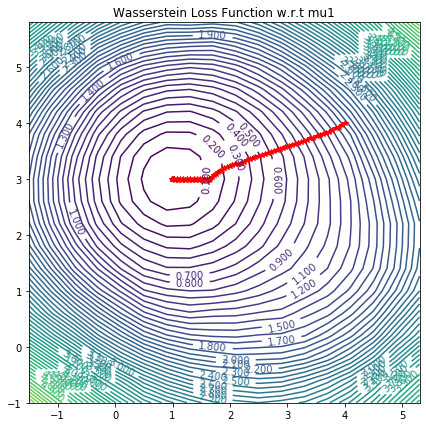

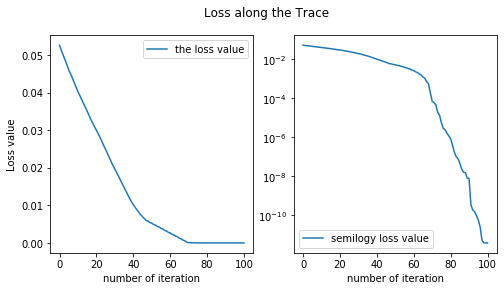

In [46]:
savepath1 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/std-GD-mu1-d3-4432-d05-contour"
savepath2 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/std-GD-mu1-d3-4432-d05-trace"
prange_mu1 = np.array([[-1, 6], [-1.5, 5.5]]);
std_GD_mu1_trace, std_GD_mu1_value = std_GD_mu1(X, Z_mu1, np.array([.3]), np.array([3, 2]), .05, 
             np.array([4, 4]), 100, prange_mu1, ytruth, costM, savepath1, savepath2);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
no descent direction available
92
no descent direction available
93
no descent direction available
94
no descent direction available
95
no descent direction available
96
no descent direction available
97
no descent direction available
98
no descent direction available
99
no descent direction available
Initial parameter values:
mu1:[4,4] 
Optimized parameter values:
mu1:[1.0, 3.0] 
Time for 100 steps is 794.2206521034241 seconds.
The average time for each step is 7.94220652103424 seconds.


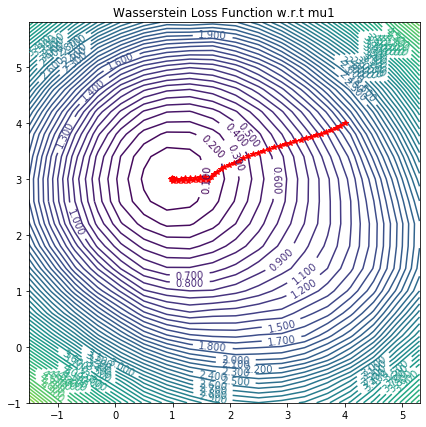

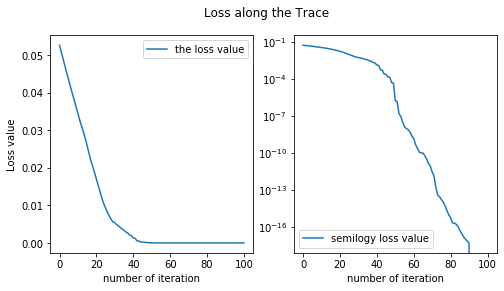

In [47]:
savepath1 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/nat-GD-mu1-d3-4432-d02-bd025-contour"
savepath2 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/nat-GD-mu1-d3-4432-d02-bd025-trace"
prange_mu1 = np.array([[-1, 6], [-1.5, 5.5]]);
nat_GD_mu1_trace, nat_GD_mu1_value = Natural_GD_mu1(X, Z_mu1, np.array([.3]), np.array([3, 2]), .02, 
             np.array([4, 4]), 100, prange_mu1, ytruth, costM, savepath1, savepath2);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Initial parameter values:
mu1:[4,4] 
Optimized parameter values:
mu1:[1.0, 3.0] 
Time for 100 steps is 345.2559697628021 seconds.
The average time for each step is 3.452559697628021 seconds.


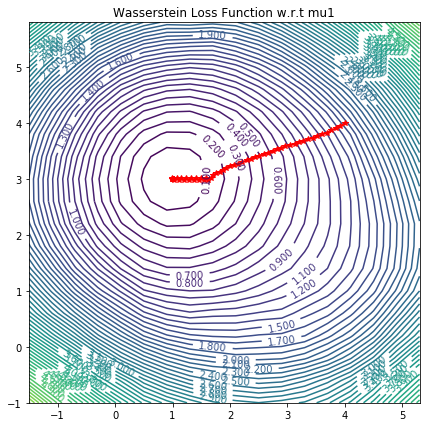

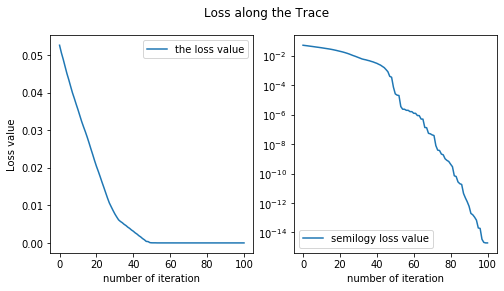

In [48]:
savepath1 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/l2-GD-mu1-d3-4432-d001-bd025-contour"
savepath2 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/l2-GD-mu1-d3-4432-d001-bd025-trace"
prange_mu1 = np.array([[-1, 6], [-1.5, 5.5]]);
l2_GD_mu1_trace, l2_GD_mu1_value = l2_Natural_GD_mu1(X, Z_mu1, np.array([.3]), np.array([3, 2]), .001, 
             np.array([4, 4]), 100, prange_mu1, ytruth, costM, savepath1, savepath2);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Initial parameter values:
mu1:[1.5,4.5] 
Optimized parameter values:
mu1:[1.0, 3.0] 
Time for 40 steps is 143.57285618782043 seconds.
The average time for each step is 3.589321404695511 seconds.


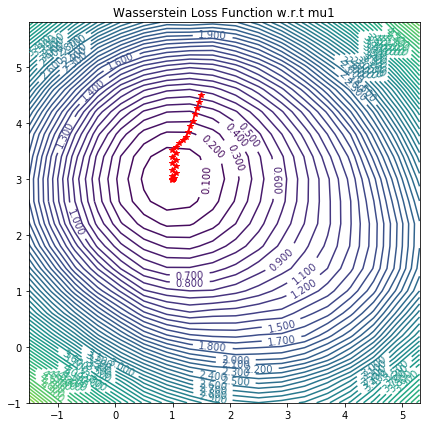

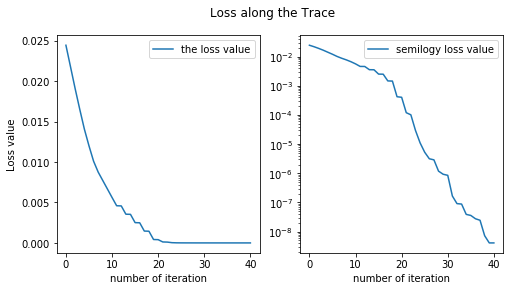

In [50]:
savepath1 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/std-GD-mu1-d3-1d54d532-d1-contour"
savepath2 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/std-GD-mu1-d3-1d54d532-d1-trace"
prange_mu1 = np.array([[-1, 6], [-1.5, 5.5]]);
std_GD_mu1_trace, std_GD_mu1_value = std_GD_mu1(X, Z_mu1, np.array([.3]), np.array([3, 2]), .1, 
             np.array([1.5, 4.5]), 40, prange_mu1, ytruth, costM, savepath1, savepath2);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
Initial parameter values:
mu1:[-0.5,1.5] 
Optimized parameter values:
mu1:[1.0, 3.0] 
Time for 60 steps is 130.4997000694275 seconds.
The average time for each step is 2.1749950011571246 seconds.


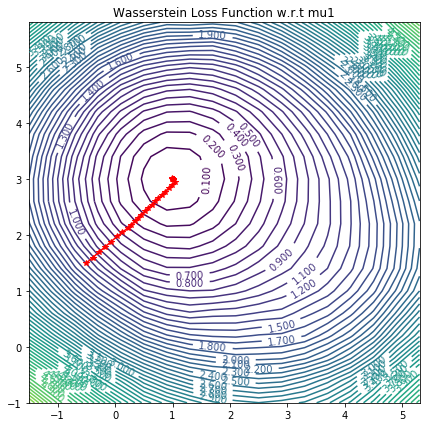

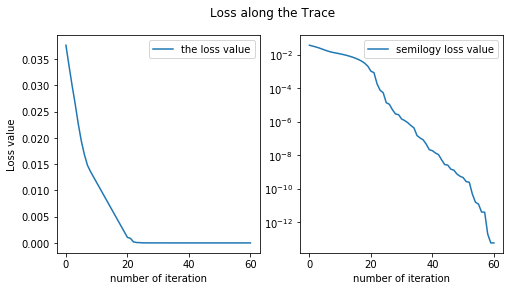

In [52]:
savepath1 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/std-GD-mu1-d3-nd51d532-d1-30iter-contour"
savepath2 = "/Users/leiwanzhou/Desktop/Wasserstein-4para/std-GD-mu1-d3-nd51d532-d1-30iter-trace"
prange_mu1 = np.array([[-1, 6], [-1.5, 5.5]]);
std_GD_mu1_trace, std_GD_mu1_value = std_GD_mu1(X, Z_mu1, np.array([.3]), np.array([3, 2]), .1, 
             np.array([-0.5, 1.5]), 60, prange_mu1, ytruth, costM, savepath1, savepath2);

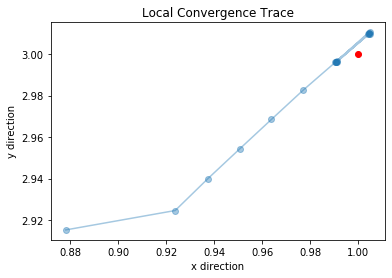

In [168]:
path =  "/Users/leiwanzhou/Desktop/Wasserstein-4para/std-GD-mu1-d3-nd51d532-d005-30iter-localtrace"
plt.plot(std_GD_mu1_trace[13:][:, 0], std_GD_mu1_trace[13:][:, 1], 'o-', alpha = .4)
plt.title("Local Convergence Trace");
plt.scatter(1, 3, color='r')
plt.xlabel("x direction");
plt.ylabel("y direction")
plt.savefig(path, dpi=300);

-1.0, -1.0
-1.0, -0.5
-1.0, 0.0
-1.0, 0.5
-1.0, 1.0
-1.0, 1.5
-1.0, 2.0
-1.0, 2.5
-1.0, 3.0
-1.0, 3.5
-1.0, 4.0
-1.0, 4.5
-1.0, 5.0
-1.0, 5.5
-0.5, -1.0
-0.5, -0.5
-0.5, 0.0
-0.5, 0.5
-0.5, 1.0
-0.5, 1.5
-0.5, 2.0
-0.5, 2.5
-0.5, 3.0
-0.5, 3.5
-0.5, 4.0
-0.5, 4.5
-0.5, 5.0
-0.5, 5.5
0.0, -1.0
0.0, -0.5
0.0, 0.0
0.0, 0.5
0.0, 1.0
0.0, 1.5
0.0, 2.0
0.0, 2.5
0.0, 3.0
0.0, 3.5
0.0, 4.0
0.0, 4.5
0.0, 5.0
0.0, 5.5
0.5, -1.0
0.5, -0.5
0.5, 0.0
0.5, 0.5
0.5, 1.0
0.5, 1.5
0.5, 2.0
0.5, 2.5
0.5, 3.0
0.5, 3.5
0.5, 4.0
0.5, 4.5
0.5, 5.0
0.5, 5.5
1.0, -1.0
1.0, -0.5
1.0, 0.0
1.0, 0.5
1.0, 1.0
1.0, 1.5
1.0, 2.0
1.0, 2.5
1.0, 3.0


/Users/leiwanzhou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


1.0, 3.5
1.0, 4.0
1.0, 4.5
1.0, 5.0
1.0, 5.5
1.5, -1.0
1.5, -0.5
1.5, 0.0
1.5, 0.5
1.5, 1.0
1.5, 1.5
1.5, 2.0
1.5, 2.5
1.5, 3.0
1.5, 3.5
1.5, 4.0
1.5, 4.5
1.5, 5.0
1.5, 5.5
2.0, -1.0
2.0, -0.5
2.0, 0.0
2.0, 0.5
2.0, 1.0
2.0, 1.5
2.0, 2.0
2.0, 2.5
2.0, 3.0
2.0, 3.5
2.0, 4.0
2.0, 4.5
2.0, 5.0
2.0, 5.5
2.5, -1.0
2.5, -0.5
2.5, 0.0
2.5, 0.5
2.5, 1.0
2.5, 1.5
2.5, 2.0
2.5, 2.5
2.5, 3.0
2.5, 3.5
2.5, 4.0
2.5, 4.5
2.5, 5.0
2.5, 5.5
3.0, -1.0
3.0, -0.5
3.0, 0.0
3.0, 0.5
3.0, 1.0
3.0, 1.5
3.0, 2.0
3.0, 2.5
3.0, 3.0
3.0, 3.5
3.0, 4.0
3.0, 4.5
3.0, 5.0
3.0, 5.5
3.5, -1.0
3.5, -0.5
3.5, 0.0
3.5, 0.5
3.5, 1.0
3.5, 1.5
3.5, 2.0
3.5, 2.5
3.5, 3.0
3.5, 3.5
3.5, 4.0
3.5, 4.5
3.5, 5.0
3.5, 5.5
4.0, -1.0
4.0, -0.5
4.0, 0.0
4.0, 0.5
4.0, 1.0
4.0, 1.5
4.0, 2.0
4.0, 2.5
4.0, 3.0
4.0, 3.5
4.0, 4.0
4.0, 4.5
4.0, 5.0
4.0, 5.5
4.5, -1.0
4.5, -0.5
4.5, 0.0
4.5, 0.5
4.5, 1.0
4.5, 1.5
4.5, 2.0
4.5, 2.5
4.5, 3.0
4.5, 3.5
4.5, 4.0
4.5, 4.5
4.5, 5.0
4.5, 5.5
5.0, -1.0
5.0, -0.5
5.0, 0.0
5.0, 0.5
5.0, 1.0
5.0, 1.5
5.0

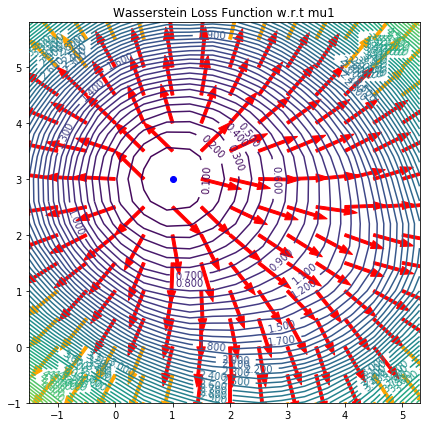

In [44]:
#Vector field of gradient of loss function w.r.t mu1 only
#cov matrix .5, 28 by 26, N = 31
savepath = "/Users/leiwanzhou/Desktop/Wasserstein-4para/gradient-at-each-point-covd5-26by26-N51"
yrange = np.array([-1.5, 5.5]); xrange = np.array([-1, 6]);
x = np.arange(xrange[0],xrange[1],grid);
y = np.arange(yrange[0],yrange[1],grid);
P,Q = np.meshgrid(x,y)
fig, ax = plt.subplots(figsize=(7, 7));
level = np.arange(0, 7, 0.1);
CS = ax.contour(Q, P, Z_mu1,levels = level);
ax.clabel(CS, inline=True, fontsize=10);
ax.set_title('Wasserstein Loss Function w.r.t mu1')
for i in np.arange(-1, 6, 0.5):
    for j in np.arange(-1, 6, 0.5):
        print("{}, {}".format(i, j));
        mu = np.array([i, j]);
        Loss, drodu = W2loss_dudro(X, 2, np.array([mu, [3, 2]]), np.array([.3]), ytruth, costM);
        p, direct = gradient_mu1_all(X, .3, np.array(mu), np.array([3, 2]), drodu);
        length = np.linalg.norm(direct);
        direct /= 2*length;
        if (length==0):
            plt.scatter(i, j, c='blue');
        elif (length<5):
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='r', ec='r');
        elif (length<10):
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='orange', ec='orange');
        elif (length<30):
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='y', ec='y');
        elif (length<50):
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='green', ec='green');
        elif (length<1500):
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='blue', ec='blue');
        else:
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='k', ec='k');
plt.savefig(savepath, dpi=300);

-1.0, -1.0
-1.0, -0.5
-1.0, 0.0
-1.0, 0.5
-1.0, 1.0
-1.0, 1.5
-1.0, 2.0
-1.0, 2.5
-1.0, 3.0
-1.0, 3.5
-1.0, 4.0
-1.0, 4.5
-1.0, 5.0
-1.0, 5.5
-0.5, -1.0
-0.5, -0.5
-0.5, 0.0
-0.5, 0.5
-0.5, 1.0
-0.5, 1.5
-0.5, 2.0
-0.5, 2.5
-0.5, 3.0
-0.5, 3.5
-0.5, 4.0
-0.5, 4.5
-0.5, 5.0
-0.5, 5.5
0.0, -1.0
0.0, -0.5
0.0, 0.0
0.0, 0.5
0.0, 1.0
0.0, 1.5
0.0, 2.0
0.0, 2.5
0.0, 3.0
0.0, 3.5
0.0, 4.0
0.0, 4.5
0.0, 5.0
0.0, 5.5
0.5, -1.0
0.5, -0.5
0.5, 0.0
0.5, 0.5
0.5, 1.0
0.5, 1.5
0.5, 2.0
0.5, 2.5
0.5, 3.0
0.5, 3.5
0.5, 4.0
0.5, 4.5
0.5, 5.0
0.5, 5.5
1.0, -1.0
1.0, -0.5
1.0, 0.0
1.0, 0.5
1.0, 1.0
1.0, 1.5
1.0, 2.0
1.0, 2.5
1.0, 3.0
1.0, 3.5
1.0, 4.0
1.0, 4.5
1.0, 5.0
1.0, 5.5
1.5, -1.0
1.5, -0.5
1.5, 0.0
1.5, 0.5
1.5, 1.0
1.5, 1.5
1.5, 2.0
1.5, 2.5
1.5, 3.0
1.5, 3.5
1.5, 4.0
1.5, 4.5
1.5, 5.0
1.5, 5.5
2.0, -1.0
2.0, -0.5
2.0, 0.0
2.0, 0.5
2.0, 1.0
2.0, 1.5
2.0, 2.0
2.0, 2.5
2.0, 3.0
2.0, 3.5
2.0, 4.0
2.0, 4.5
2.0, 5.0
2.0, 5.5
2.5, -1.0
2.5, -0.5
2.5, 0.0
2.5, 0.5
2.5, 1.0
2.5, 1.5
2.5, 2.0
2.5, 2.5
2.

/Users/leiwanzhou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


3.0, 2.5
3.0, 3.0
3.0, 3.5
3.0, 4.0
3.0, 4.5
3.0, 5.0
3.0, 5.5
3.5, -1.0
3.5, -0.5
3.5, 0.0
3.5, 0.5
3.5, 1.0
3.5, 1.5
3.5, 2.0
3.5, 2.5
3.5, 3.0
3.5, 3.5
3.5, 4.0
3.5, 4.5
3.5, 5.0
3.5, 5.5
4.0, -1.0
4.0, -0.5
4.0, 0.0
4.0, 0.5
4.0, 1.0
4.0, 1.5
4.0, 2.0
4.0, 2.5
4.0, 3.0
4.0, 3.5
4.0, 4.0
4.0, 4.5
4.0, 5.0
4.0, 5.5
4.5, -1.0
4.5, -0.5
4.5, 0.0
4.5, 0.5
4.5, 1.0
4.5, 1.5
4.5, 2.0
4.5, 2.5
4.5, 3.0
4.5, 3.5
4.5, 4.0
4.5, 4.5
4.5, 5.0
4.5, 5.5
5.0, -1.0
5.0, -0.5
5.0, 0.0
5.0, 0.5
5.0, 1.0
5.0, 1.5
5.0, 2.0
5.0, 2.5
5.0, 3.0
5.0, 3.5
5.0, 4.0
5.0, 4.5
5.0, 5.0
5.0, 5.5
5.5, -1.0
5.5, -0.5
5.5, 0.0
5.5, 0.5
5.5, 1.0
5.5, 1.5
5.5, 2.0
5.5, 2.5
5.5, 3.0
5.5, 3.5
5.5, 4.0
5.5, 4.5
5.5, 5.0
5.5, 5.5


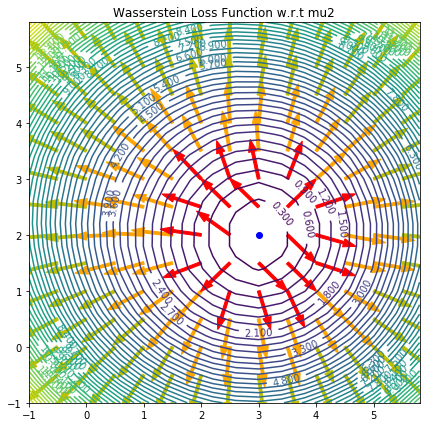

In [45]:
savepath = "/Users/leiwanzhou/Desktop/Wasserstein-4para/gradient-mu2-at-each-point-covd5-26by26-N51"
yrange = np.array([-1, 6]); xrange = np.array([-1, 6]);
x = np.arange(xrange[0],xrange[1],grid);
y = np.arange(yrange[0],yrange[1],grid);
P,Q = np.meshgrid(x,y)
fig, ax = plt.subplots(figsize=(7, 7));
level = np.arange(0, 16, 0.3);
CS = ax.contour(Q, P, Z_mu2,levels = level);
ax.clabel(CS, inline=True, fontsize=10);
ax.set_title('Wasserstein Loss Function w.r.t mu2')
for i in np.arange(-1, 6, 0.5):
    for j in np.arange(-1, 6, 0.5):
        print("{}, {}".format(i, j));
        mu = np.array([i, j]);
        Loss, drodu = W2loss_dudro(X, 2, np.array([[1, 3], mu]), np.array([.3]), ytruth, costM);
        p, direct = gradient_mu2_all(X, .3, np.array([1, 3]), np.array(mu), drodu);
        length = np.linalg.norm(direct);
        direct /= 2*length;
        if (length==0):
            plt.scatter(i, j, c='blue');
        elif (length<5):
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='r', ec='r');
        elif (length<10):
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='orange', ec='orange');
        elif (length<30):
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='y', ec='y');
        elif (length<50):
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='green', ec='green');
        elif (length<1500):
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='blue', ec='blue');
        else:
            plt.arrow(i, j, direct[0], direct[1], width=0.05, fc='k', ec='k');
plt.savefig(savepath, dpi=300);